In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = 'F:\\Guvi Projects\\Mental_Health_Survey\\Datasets\\preprocessed_data.csv'

In [3]:
data = pd.read_csv(file_path)

In [4]:
data.head()

,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,49,15,1,4,0,1,0,9,0,1,2,0,0
1,1,26,26,1,36,0,2,2,12,1,7,3,0,1
2,1,33,28,0,28,5,0,0,3,1,3,1,0,1
3,1,22,17,1,36,0,2,1,6,1,10,1,1,1
4,0,30,12,1,3,0,0,2,6,1,9,4,1,0


In [5]:
data.shape

(135769, 14)

In [6]:
data['Depression'].value_counts()

Depression
0    111197
1     24572
Name: count, dtype: int64

In [7]:
val = data.drop('Depression', axis = 1)
tar = data['Depression']

In [8]:
# Imbalance

sampler = RandomOverSampler(random_state = 65)

In [9]:
os_val, os_tar = sampler.fit_resample(val, tar)

In [10]:
# feature selection

fs = RandomForestClassifier(n_estimators= 200, max_depth= 3, random_state= 65)

fs.fit(os_val, os_tar)

RandomForestClassifier(max_depth=3, n_estimators=200, random_state=65)

In [11]:
s_col = pd.DataFrame({
    "col": os_val.columns,
    "score": fs.feature_importances_
}).sort_values('score', ascending = False). head(10)['col'].to_list()

In [12]:
s_col

['Age',
 'Academic Pressure',
 'Working Professional or Student',
 'Have you ever had suicidal thoughts ?',
 'Profession',
 'Financial Stress',
 'Work/Study Hours',
 'Dietary Habits',
 'Degree',
 'Sleep Duration']

In [13]:
# Train Test Split

tr_data, ts_data, tr_lab, ts_lab = train_test_split(os_val, os_tar, test_size = 0.2, random_state = 65)

In [14]:
tr_data.shape, ts_data.shape, tr_lab.shape, ts_lab.shape

((177915, 13), (44479, 13), (177915,), (44479,))

In [15]:
model = Sequential([
    Dense(100, activation='relu', input_shape=(tr_data.shape[1],)),
    BatchNormalization(), 
    Dropout(0.3),  

    Dense(65, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(35, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(15, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='relu'),

    Dense(1, activation='sigmoid')
])

In [16]:
optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [18]:
history = model.fit(tr_data, tr_lab, validation_data=(ts_data, ts_lab),
                    epochs=50, batch_size=64, callbacks=[early_stopping], verbose=1)

Epoch 1/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8591 - loss: 0.3358 - val_accuracy: 0.9081 - val_loss: 0.2342
Epoch 2/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8980 - loss: 0.2589 - val_accuracy: 0.9066 - val_loss: 0.2348
Epoch 3/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8995 - loss: 0.2547 - val_accuracy: 0.9079 - val_loss: 0.2458
Epoch 4/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9002 - loss: 0.2533 - val_accuracy: 0.9074 - val_loss: 0.2364
Epoch 5/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9028 - loss: 0.2479 - val_accuracy: 0.9089 - val_loss: 0.2337
Epoch 6/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9010 - loss: 0.2490 - val_accuracy: 0.9080 - val_loss: 0.2318
Epoch 7/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9007 - loss: 0.2488 - val_accuracy: 0.9064 - val_loss: 0.2382
Epoch 8/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9034 - loss: 0.2453 - 

In [19]:
ts_pred = (model.predict(ts_data) > 0.5).astype(int)

1390/1390 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step


In [20]:
ts_probs = model.predict(ts_data).flatten()

1390/1390 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step


In [21]:
fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

In [22]:
auc_score = roc_auc_score(ts_lab, ts_probs)

In [23]:
accuracy = accuracy_score(ts_lab, ts_pred)
precision = precision_score(ts_lab, ts_pred)
recall = recall_score(ts_lab, ts_pred)
f1 = f1_score(ts_lab, ts_pred)

In [24]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print("\n =============== Classification Report: ===============")
print(f"\n {classification_report(ts_lab, ts_pred)}")

Test Accuracy: 0.9089
Test Precision: 0.9006
Test Recall: 0.9198
Test F1-Score: 0.9101

 =============== Classification Report: ===============

               precision    recall  f1-score   support

           0       0.92      0.90      0.91     22178
           1       0.90      0.92      0.91     22301

    accuracy                           0.91     44479
   macro avg       0.91      0.91      0.91     44479
weighted avg       0.91      0.91      0.91     44479



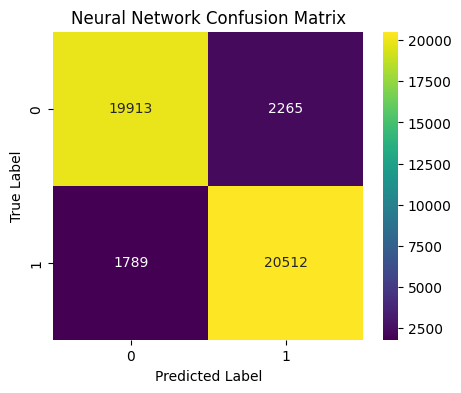

In [25]:
plt.figure(figsize=(5, 4))
cm = confusion_matrix(ts_lab, ts_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Neural Network Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

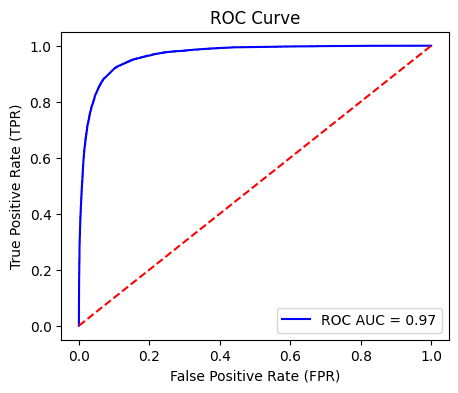

In [26]:
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [27]:
model.save('F:\\Guvi Projects\\Mental_Health_Survey\\Model\\neural_network.keras')
print('Model Successfully Saved to \Models')

Model Successfully Saved to \Models
